SAR IMAGE COLORIZATION

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [3]:
import tensorflow as tf

# Load the saved generator model
generator = tf.keras.models.load_model('/kaggle/input/pix2pix-model/pix2pix_generator.h5')  # Adjust path as needed
# Load the saved discriminator model
discriminator = tf.keras.models.load_model('/kaggle/input/pix2pix-model/pix2pix_discriminator.h5')  # Adjust path as needed


In [2]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Define U-Net Generator
def unet_generator(output_channels):
    inputs = layers.Input(shape=[256, 256, 3])  # Adjust input size as needed

    # Downsampling layers (Encoder)
    down_stack = [
        layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2D(512, 4, strides=2, padding='same', activation='relu')
    ]

    # Upsampling layers (Decoder)
    up_stack = [
        layers.Conv2DTranspose(512, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(256, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(128, 4, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(64, 4, strides=2, padding='same', activation='relu'),
    ]

    # Connect layers with skip connections
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])  # Skip the last encoding layer (smallest)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    outputs = layers.Conv2DTranspose(output_channels, 4, strides=2, padding='same', activation='tanh')(x)
    return Model(inputs=inputs, outputs=outputs)

# Initialize generator
generator = unet_generator(output_channels=3)  # RGB output
generator.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          3,136 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 8, 8, 512)      │      4,194,816 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      4,194,816 │ conv2d_4[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 256)    │      4,194,560 │ concatenate[0][0]      │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 32, 32, 512)    │              0 │ conv2d_transpose_1[0]… │
│ (Concatenate)             │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_2        │ (None, 64, 64, 128)    │      1,048,704 │ concatenate_1[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 64, 64, 256)    │              0 │ conv2d_transpose_2[0]… │
│ (Concatenate)             │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 128, 128, 64)   │        262,208 │ concatenate_2[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_3[0]… │
│ (Concatenate)             │                        │                │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 256, 256, 3)    │          6,147 │ concatenate_3[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
└──────────────────────

 Total params: 16,657,795 (63.54 MB)

 Trainable params: 16,657,795 (63.54 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Define PatchGAN Discriminator
def patchgan_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.InputLayer(input_shape=[256, 256, 3]))  # Adjust input shape
    model.add(layers.Conv2D(64, 4, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2D(128, 4, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2D(256, 4, strides=2, padding='same', activation='relu'))
    model.add(layers.Conv2D(1, 4, strides=1, padding='same', activation='sigmoid'))  # Binary classification (real or fake)
    return model

# Initialize discriminator
discriminator = patchgan_discriminator()
discriminator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 32, 32, 1)           │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 128, 128, 64)   │          3,136 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 64, 64, 128)    │        131,200 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 256)    │        524,544 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 512)      │      4,194,816 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 16, 16, 512)    │      4,194,816 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_4             │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose_5[0]… │
│ (Concatenate)             │                        │                │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_6        │ (None, 32, 32, 256)    │      4,194,560 │ concatenate_4[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, 32, 32, 512)    │              0 │ conv2d_transpose_6[0]… │
│ (Concatenate)             │                        │                │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_7        │ (None, 64, 64, 128)    │      1,048,704 │ concatenate_5[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_6             │ (None, 64, 64, 256)    │              0 │ conv2d_transpose_7[0]… │
│ (Concatenate)             │                        │                │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_8        │ (None, 128, 128, 64)   │        262,208 │ concatenate_6[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 128, 128, 128)  │              0 │ conv2d_transpose_8[0]… │
│ (Concatenate)             │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_9        │ (None, 256, 256, 3)    │          6,147 │ concatenate_7[0][0]    │
│ (Conv2DTranspose)    

 Total params: 16,657,795 (63.54 MB)

 Trainable params: 16,657,795 (63.54 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
discriminator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 32, 32, 1)           │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 662,977 (2.53 MB)

 Trainable params: 662,977 (2.53 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Loss functions
def generator_loss(disc_generated_output, gen_output, target):
    # L1 loss (pixel-wise difference) + Adversarial loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    gan_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_generated_output, labels=tf.ones_like(disc_generated_output)))
    return gan_loss + 100 * l1_loss

def discriminator_loss(disc_real_output, disc_generated_output):
    # Binary cross-entropy loss for discriminator
    real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_output, labels=tf.ones_like(disc_real_output)))
    generated_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_generated_output, labels=tf.zeros_like(disc_generated_output)))
    return real_loss + generated_loss

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [13]:
### load the dataset

In [18]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load a batch of paired images (SAR and RGB from separate directories)
def load_images(sar_dir, rgb_dir, image_size=(256, 256)):
    sar_images = []
    rgb_images = []
    
    # List files in the SAR and RGB directories
    sar_files = os.listdir(sar_dir)
    rgb_files = os.listdir(rgb_dir)
    
    # Ensure the filenames are the same (excluding directory)
    sar_files = [file for file in sar_files if file.endswith('.png')]
    rgb_files = [file for file in rgb_files if file.endswith('.png')]

    # Debugging: Check if both directories contain the same number of images
    print(f"Found {len(sar_files)} SAR images and {len(rgb_files)} RGB images.")

    for idx in range(len(sar_files)):
        # Ensure corresponding RGB image exists
        image_file=sar_files[idx]
        rgb_image_path = rgb_files[idx]  # Assuming same filename for SAR and RGB images

        if rgb_image_path in rgb_files:
            try:
                # Load and preprocess SAR image (grayscale)
                sar_image = load_img(os.path.join(sar_dir, image_file), target_size=image_size, color_mode='grayscale')
                sar_image = img_to_array(sar_image)
                sar_image = (sar_image - 127.5) / 127.5  # Normalize to [-1, 1]
                
                # Debugging: Print shape of the SAR image
                # print(f"SAR image shape: {sar_image.shape}")
                
                # Check if the image is valid
                if sar_image.shape != (image_size[0], image_size[1], 1):
                    print(f"Skipping invalid SAR image: {image_file}")
                    continue
                sar_images.append(sar_image)

                # Load and preprocess RGB image (color)
                rgb_image = load_img(os.path.join(rgb_dir, rgb_image_path), target_size=image_size)
                rgb_image = img_to_array(rgb_image)
                rgb_image = (rgb_image - 127.5) / 127.5  # Normalize to [-1, 1]
                
                # Debugging: Print shape of the RGB image
                # print(f"RGB image shape: {rgb_image.shape}")
                
                # Check if the image is valid
                if rgb_image.shape != (image_size[0], image_size[1], 3):
                    print(f"Skipping invalid RGB image: {image_file}")
                    continue
                rgb_images.append(rgb_image)

            except Exception as e:
                print(f"Error loading {image_file}: {e}")
                continue
    return np.array(sar_images), np.array(rgb_images)

# Path to the directories for SAR (S1) and RGB (S2) images
sar_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1"  # Update with the correct path
rgb_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2"  # Update with the correct path

# Load SAR and RGB image pairs from the specified directories
sar_images, rgb_images = load_images(sar_dir, rgb_dir, image_size=(256, 256))

# Check the shapes of the loaded images
print(sar_images.shape, rgb_images.shape)


Found 4000 SAR images and 4000 RGB images.


KeyboardInterrupt: 

In [7]:
# Modify to load SAR and RGB images from separate directories
def load_images_from_directory(sar_dir, rgb_dir, image_size=(256, 256)):
    sar_images = []
    rgb_images = []

    # List all files in the SAR and RGB directories
    sar_files = os.listdir(sar_dir)
    rgb_files = os.listdir(rgb_dir)

    # Sort the files so they match correctly
    sar_files.sort()
    rgb_files.sort()

    for sar_file, rgb_file in zip(sar_files, rgb_files):
        if sar_file.endswith(".png") and rgb_file.endswith(".png"):
            # Load and preprocess SAR image (grayscale)
            sar_image = load_img(os.path.join(sar_dir, sar_file), target_size=image_size, color_mode='grayscale')
            sar_image = img_to_array(sar_image)
            sar_image = np.repeat(sar_image, 3, axis=-1)  # Convert grayscale to RGB by duplicating the channel
            sar_image = (sar_image - 127.5) / 127.5  # Normalize to [-1, 1]
            sar_images.append(sar_image)

            # Load and preprocess RGB image (color)
            rgb_image = load_img(os.path.join(rgb_dir, rgb_file), target_size=image_size)
            rgb_image = img_to_array(rgb_image)
            rgb_image = (rgb_image - 127.5) / 127.5  # Normalize to [-1, 1]
            rgb_images.append(rgb_image)

    return np.array(sar_images), np.array(rgb_images)

# Replace with the correct paths to your directories
sar_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s1"
rgb_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/agri/s2"

# Load the images
sar_images, rgb_images = load_images_from_directory(sar_dir, rgb_dir, image_size=(256, 256))

# Check the shape of loaded images
print(sar_images.shape, rgb_images.shape)


(4000, 256, 256, 3) (4000, 256, 256, 3)


In [8]:
# Convert to tf.data.Dataset
import tensorflow as tf

# Create a tf.data.Dataset for training
def create_dataset(sar_images, rgb_images, batch_size=16):
    # Convert to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((sar_images, rgb_images))
    
    # Shuffle, batch, and prefetch the data
    dataset = dataset.shuffle(buffer_size=len(sar_images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create the dataset
batch_size = 16
train_dataset = create_dataset(sar_images, rgb_images, batch_size=batch_size)

# Check the shape of one batch
for input_image, target in train_dataset.take(1):
    print(f"Input Image shape: {input_image.shape}, Target Image shape: {target.shape}")


Input Image shape: (16, 256, 256, 3), Target Image shape: (16, 256, 256, 3)


In [9]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake image
        gen_output = generator(input_image, training=True)

        # Discriminator outputs
        disc_real_output = discriminator(target, training=True)
        disc_generated_output = discriminator(gen_output, training=True)

        # Calculate losses
        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Compute gradients
    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients
    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [10]:
# Define the training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        print(f"Starting Epoch {epoch + 1}/{epochs}")
        for input_image, target in dataset:
            gen_loss, disc_loss = train_step(input_image, target)
        print(f"Epoch {epoch + 1}: Gen Loss: {gen_loss}, Disc Loss: {disc_loss}")

In [11]:
# Start the training process 
epochs = 25  # Set the number of epochs
train(train_dataset, epochs)

Starting Epoch 1/25
Epoch 1: Gen Loss: 13.98087215423584, Disc Loss: 1.0101268291473389
Starting Epoch 2/25
Epoch 2: Gen Loss: 12.79350471496582, Disc Loss: 1.013351321220398
Starting Epoch 3/25
Epoch 3: Gen Loss: 13.135467529296875, Disc Loss: 1.010317325592041
Starting Epoch 4/25
Epoch 4: Gen Loss: 12.553598403930664, Disc Loss: 1.00896155834198
Starting Epoch 5/25
Epoch 5: Gen Loss: 13.655174255371094, Disc Loss: 1.011888027191162
Starting Epoch 6/25
Epoch 6: Gen Loss: 14.045992851257324, Disc Loss: 1.0082000494003296
Starting Epoch 7/25
Epoch 7: Gen Loss: 11.77236557006836, Disc Loss: 1.0102508068084717
Starting Epoch 8/25
Epoch 8: Gen Loss: 11.30786418914795, Disc Loss: 1.0106048583984375
Starting Epoch 9/25
Epoch 9: Gen Loss: 10.358892440795898, Disc Loss: 1.0092817544937134
Starting Epoch 10/25
Epoch 10: Gen Loss: 11.811744689941406, Disc Loss: 1.007248044013977
Starting Epoch 11/25
Epoch 11: Gen Loss: 11.824735641479492, Disc Loss: 1.0087226629257202
Starting Epoch 12/25
Epoch 

In [13]:
generator.save("pix2pix_generator.h5")
discriminator.save("pix2pix_discriminator.h5")

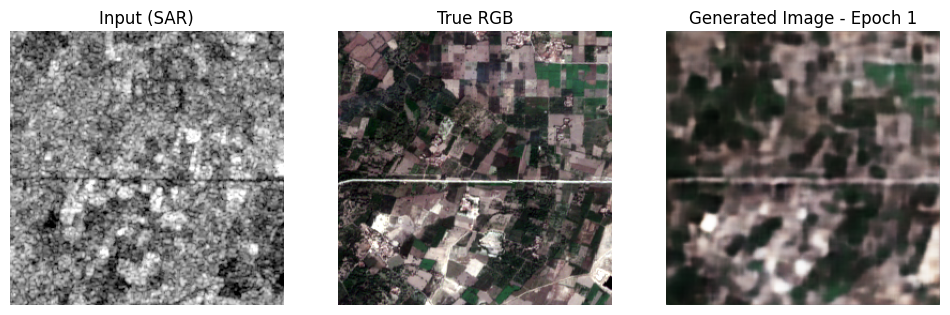

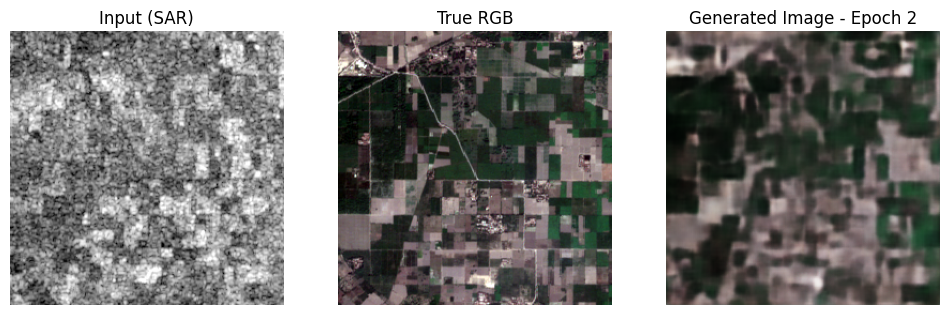

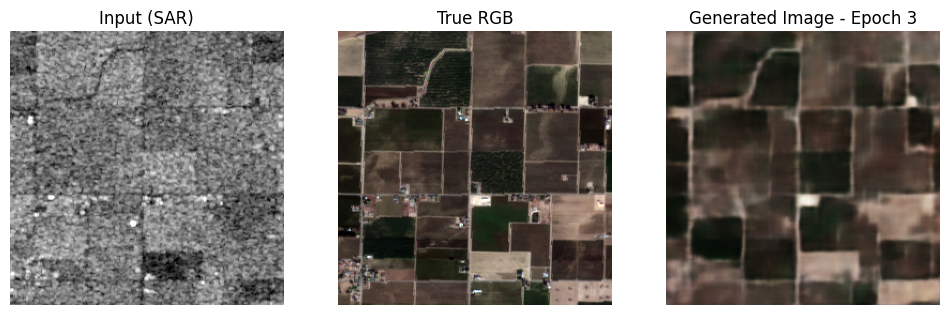

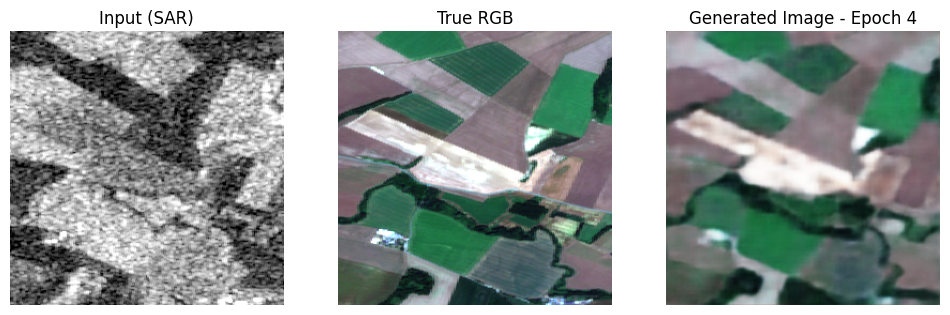

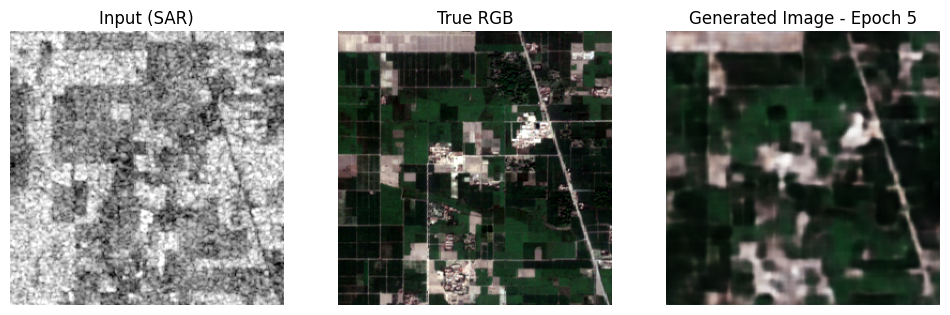

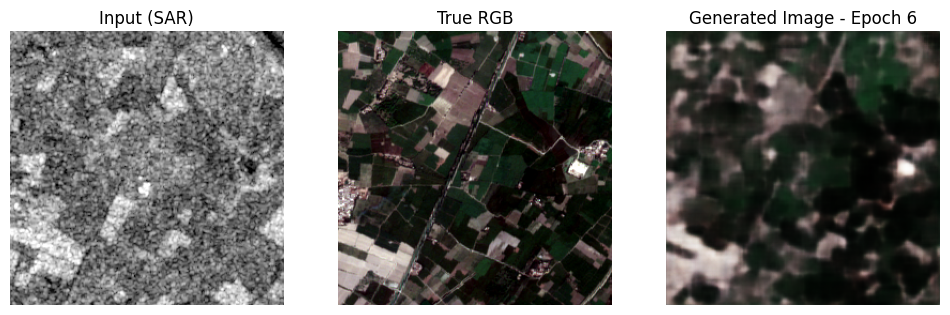

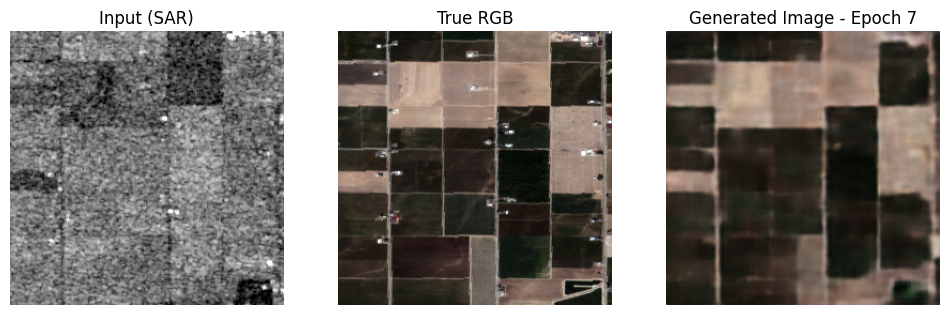

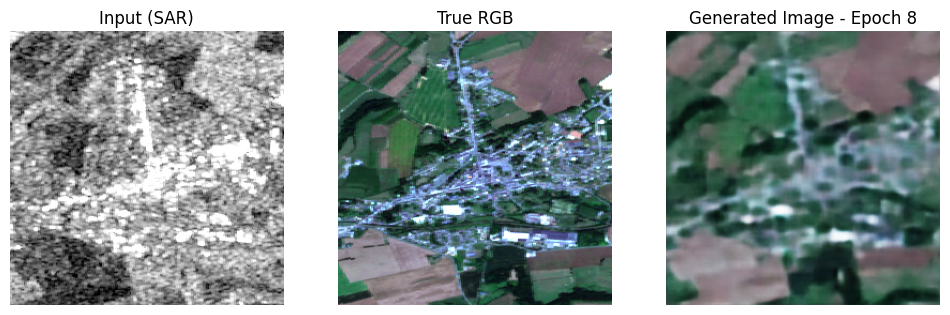

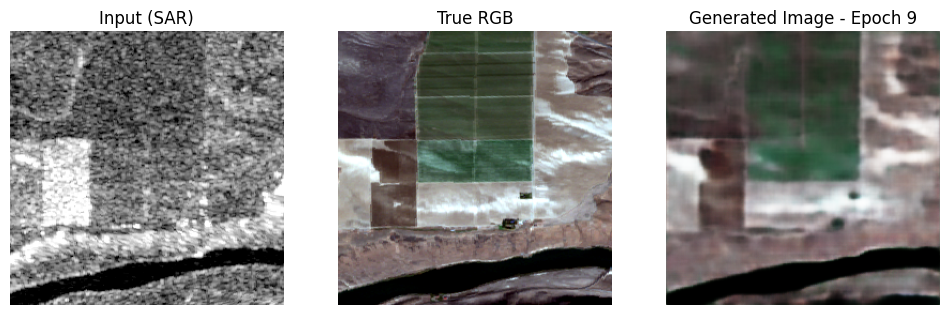

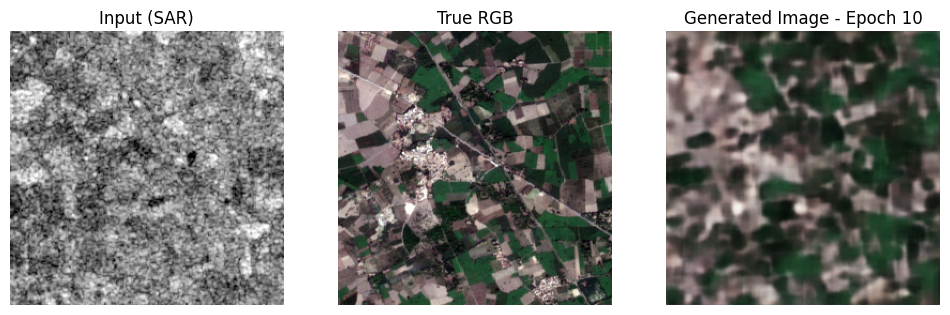

In [15]:
import matplotlib.pyplot as plt
# Visualize generated images after each epoch
def visualize_results(epoch, test_input, test_target):
    gen_output = generator(test_input, training=False)
    plt.figure(figsize=(12, 12))

    # SAR image
    plt.subplot(1, 3, 1)
    plt.imshow(test_input[0] * 0.5 + 0.5)  # Rescale back to [0, 1]
    plt.title("Input (SAR)")
    plt.axis("off")

    # True RGB image
    plt.subplot(1, 3, 2)
    plt.imshow(test_target[0] * 0.5 + 0.5)
    plt.title("True RGB")
    plt.axis("off")

    # Generated RGB image
    plt.subplot(1, 3, 3)
    plt.imshow(gen_output[0] * 0.5 + 0.5)
    plt.title(f"Generated Image - Epoch {epoch + 1}")
    plt.axis("off")

    plt.show()

# During training, visualize some images from the dataset
for epoch in range(10):
    for input_image, target in train_dataset.take(1):  # Only take the first batch
        visualize_results(epoch, input_image, target)
        break  # Show results for the first batch


In [9]:
# Modify to load SAR and RGB images from separate directories
def load_images_from_directory(sar_dir, rgb_dir, image_size=(256, 256)):
    sar_images = []
    rgb_images = []

    # List all files in the SAR and RGB directories
    sar_files = os.listdir(sar_dir)
    rgb_files = os.listdir(rgb_dir)

    # Sort the files so they match correctly
    sar_files.sort()
    rgb_files.sort()

    for sar_file, rgb_file in zip(sar_files, rgb_files):
        if sar_file.endswith(".png") and rgb_file.endswith(".png"):
            # Load and preprocess SAR image (grayscale)
            sar_image = load_img(os.path.join(sar_dir, sar_file), target_size=image_size, color_mode='grayscale')
            sar_image = img_to_array(sar_image)
            sar_image = np.repeat(sar_image, 3, axis=-1)  # Convert grayscale to RGB by duplicating the channel
            sar_image = (sar_image - 127.5) / 127.5  # Normalize to [-1, 1]
            sar_images.append(sar_image)

            # Load and preprocess RGB image (color)
            rgb_image = load_img(os.path.join(rgb_dir, rgb_file), target_size=image_size)
            rgb_image = img_to_array(rgb_image)
            rgb_image = (rgb_image - 127.5) / 127.5  # Normalize to [-1, 1]
            rgb_images.append(rgb_image)

    return np.array(sar_images), np.array(rgb_images)

# Replace with the correct paths to your directories
sar_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/barrenland/s1"
rgb_dir = "/kaggle/input/sentinel12-image-pairs-segregated-by-terrain/v_2/barrenland/s2"

# Load the images
sar_images, rgb_images = load_images_from_directory(sar_dir, rgb_dir, image_size=(256, 256))

# Check the shape of loaded images
print(sar_images.shape, rgb_images.shape)

(4000, 256, 256, 3) (4000, 256, 256, 3)


In [10]:
import tensorflow as tf

# Create a tf.data.Dataset for training
def create_dataset(sar_images, rgb_images, batch_size=16):
    # Convert to TensorFlow Dataset
    dataset = tf.data.Dataset.from_tensor_slices((sar_images, rgb_images))
    
    # Shuffle, batch, and prefetch the data
    dataset = dataset.shuffle(buffer_size=len(sar_images))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

# Create the dataset
batch_size = 16
train_dataset = create_dataset(sar_images, rgb_images, batch_size=batch_size)

# Check the shape of one batch
for input_image, target in train_dataset.take(1):
    print(f"Input Image shape: {input_image.shape}, Target Image shape: {target.shape}")


Input Image shape: (16, 256, 256, 3), Target Image shape: (16, 256, 256, 3)


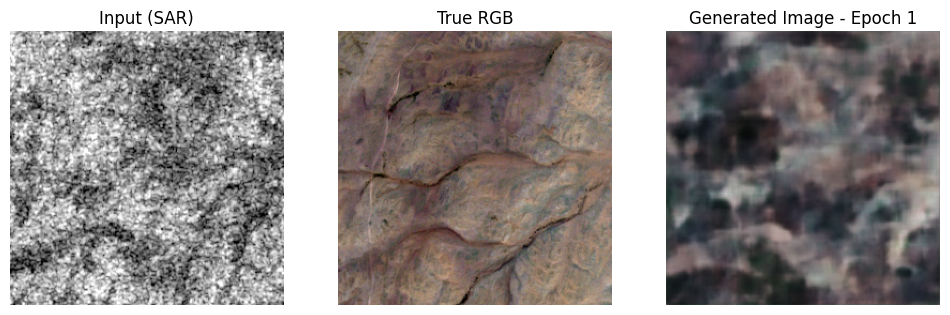

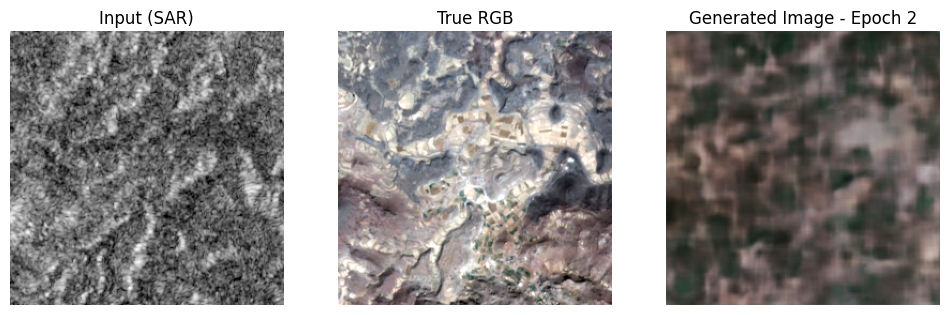

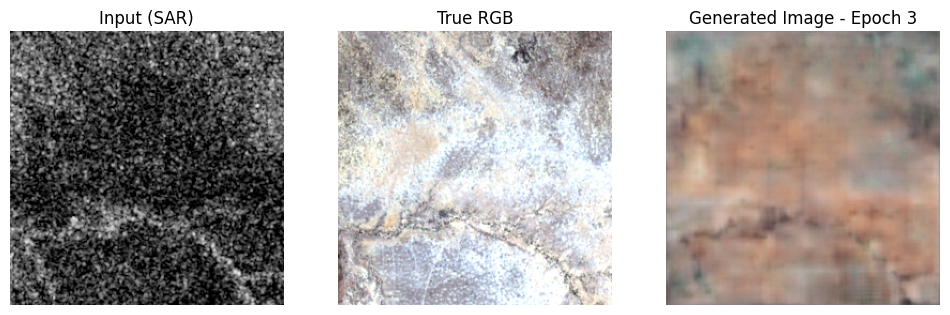

In [11]:
import matplotlib.pyplot as plt
# Visualize generated images after each epoch
def visualize_results(epoch, test_input, test_target):
    gen_output = generator(test_input, training=False)
    plt.figure(figsize=(12, 12))

    # SAR image
    plt.subplot(1, 3, 1)
    plt.imshow(test_input[0] * 0.5 + 0.5)  # Rescale back to [0, 1]
    plt.title("Input (SAR)")
    plt.axis("off")

    # True RGB image
    plt.subplot(1, 3, 2)
    plt.imshow(test_target[0] * 0.5 + 0.5)
    plt.title("True RGB")
    plt.axis("off")

    # Generated RGB image
    plt.subplot(1, 3, 3)
    plt.imshow(gen_output[0] * 0.5 + 0.5)
    plt.title(f"Generated Image - Epoch {epoch + 1}")
    plt.axis("off")

    plt.show()

# During training, visualize some images from the dataset
for epoch in range(3):
    for input_image, target in train_dataset.take(1):  # Only take the first batch
        visualize_results(epoch, input_image, target)
        break  # Show results for the first batch
